# Trotter bounds

In [2]:
from qiskit.quantum_info import SparsePauliOp

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from utils import *
from lightcone import *
from bounds import *
# from noise import *
# print(f'jax.device: {jax.devices()}; device_count: {jax.device_count()}')
from spin_ham import *

figs_dir = './figs'
data_dir = './data'

## Different norms of Pauli strings

In [7]:
op = SparsePauliOp.from_list([("XIIZI", 1), ("IYIIY", 2)])
print('Spectral norm: ', norm(op, ord=2))
print('Trace norm: ', norm(op, ord='nuc'))
print('Frobenius norm: ', norm(op, ord='fro'))
# print(norm(SparsePauliOp.from_list([("XYZI", 1)]), ord='nuc'))

Spectral norm:  3.0000000000000004
Trace norm:  63.999999999999986
Frobenius norm:  12.649110640673518


### Schatten 4norm

m_list:  [3, 4, 5, 6, 8, 10, 13, 16, 20, 24, 31]
->0->1->2->3->4->5->6->7->8->9->10a_em: 0.5199838890825015; b_em: 0.10789293976783258


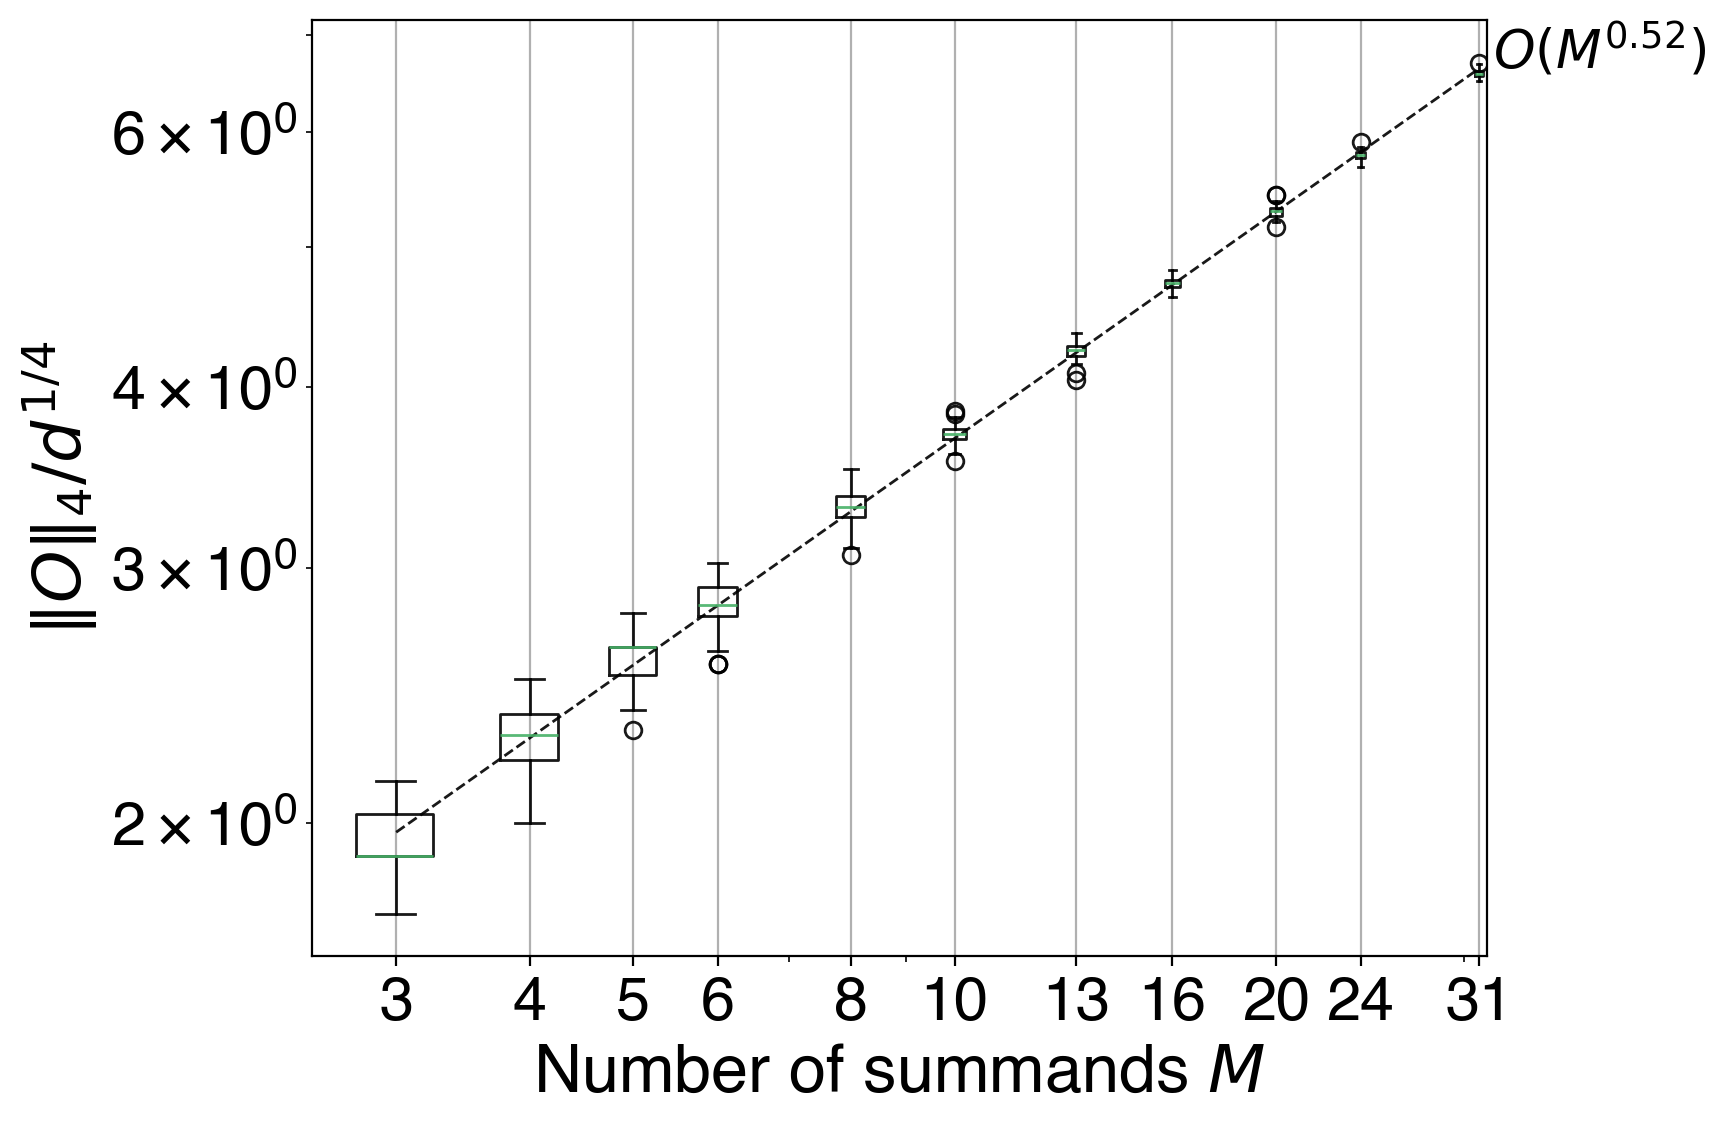

In [18]:
import matplotlib.pyplot as plt

k_list = [30]
n, k = 50, 50
n_round = 100
# n_round = 40
# m_list = np.logspace(0, 2, 15, dtype=int)
# m_list = np.logspace(0.5, 2, 15, dtype=int)
# m_list = np.logspace(0.5, 1.3, 15, dtype=int)
# m_list = np.logspace(0.5, 1.5, 15, dtype=int)
m_list = [3, 4, 5, 6, 8, 10, 13, 16, 20, 24, 31]
# m_list = np.linspace(6, 30, dtype=int)
m_list = sorted(list(set(m_list)))
print('m_list: ', m_list)
trace4o_list = []

for k in k_list:
    ob_list = []
    for m in m_list: 
        # print(m)
        p_ops_ensemble = [sum([SparsePauliOp.from_sparse_list([(random.choices(['I','X','Y','Z'], k=k), random.sample(list(range(0, n)), k), 1)], n) for _ in range(m)]) for _ in range(n_round)]
        # print(p_ops)
        ob_list.append(p_ops_ensemble)
    # print('----')
    # print(ob_list[3])
    # print((ob_list[3] @ ob_list[3] @ ob_list[3] @ ob_list[3]).simplify())
    trace4o = []
    # print(len(ob_list))
    for i, ob_ensemble in enumerate(ob_list):
        print(f'->{i}', end='')
        temp_list = []
        for ob in ob_ensemble:
            temp = (ob @ ob).simplify()
            temp_tr = (temp @ temp).simplify()[0].coeffs[0].real
            temp_list.append(temp_tr**(1/4))
        trace4o.append(temp_list)

    trace4o_list.append(trace4o)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
# ax.plot(m_list, trace4o, 'o', label='Tr(O^4)')
# ax.plot(m_list, np.array(trace4o).mean(axis=1), 'o', label='Tr(O^4)')
for trace4o in trace4o_list:
    ax.boxplot(trace4o, positions=m_list)
    # ax.errorbar(m_list, np.array(trace4o).mean(axis=1), np.array(trace4o).std(axis=1))
    plot_fit(ax, m_list, np.array(trace4o).mean(axis=1), var='M', x_offset=1.03)
ax.set_xlabel(r'Number of summands $M$')  
ax.set_ylabel(r'$\|O\|_4/d^{1/4}$')
# ax.set_ylabel(rf'Tr($O^4)/d$')
ax.loglog() 
ax.grid()
# ax.set_xticks([3, 6, 8, 11, 13, 16, 22, 25, 30])
ax.set_xticks(m_list)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
fig.savefig(f'{figs_dir}/boxplot_{k}local_4norm_n={n}_m={m}_new.pdf', dpi=150, bbox_inches='tight')

In [50]:
print(trace4o)
np.array(trace4o).mean(axis=1)
np.array(trace4o).std(axis=1)

array([  3.549648,   3.458323,   8.      ,   8.634813,   9.162969,
        12.163881,  20.45385 ,  27.868262,  29.017925,  47.448498,
        52.801136,  79.639186, 123.743444, 154.90694 , 217.749489])

In [7]:

def nested_commutator_2norm(h_list, p=2):
    L = len(h_list)
    # print('L:', L)
    if p == 2:
        sum_norm2 = 0
        for i in range(L):
            cmm = commutator(h_list[i], commutator(h_list[0], h_list[1]).simplify()).simplify()
            print((cmm @ cmm).simplify())
            print((cmm @ cmm).simplify().coeffs[0])
            if i == 0:
                sum_norm2 += (np.abs((cmm @ cmm).simplify().coeffs[0])) / 2
            else:
                sum_norm2 += (np.abs((cmm @ cmm).simplify().coeffs[0]))
        return sum_norm2

pow_law = Power_law(4, alpha=4, Jx=1, Jy=0, Jz=0, hx=0.0, hy=0.0, hz=0.2, pbc=False, verbose=False)
# print('xyz group: ', pow_law.ham_xyz)
norm2 = nested_commutator_2norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
norm2

SparsePauliOp(['IIII', 'IIZZ', 'IXXI', 'XIXI', 'IZIZ', 'XXII', 'ZIIZ', 'XXZZ', 'XZXZ', 'ZXXZ', 'IXIX', 'XIIX', 'IZZI', 'XZZX', 'ZIZI', 'ZXZX', 'IIYY', 'XXYY', 'IYIY', 'XYXY', 'YIIY', 'YXXY', 'IYYI', 'XYYX', 'YIYI', 'YXYX', 'IIXX', 'ZZII', 'ZZXX', 'YYII', 'YYXX'],
              coeffs=[1.161121e+01+0.j, 2.575657e+00+0.j, 3.213963e-01+0.j, 5.181980e+00+0.j,
 2.638620e+00+0.j, 6.465589e-01+0.j, 1.310411e+00+0.j, 1.646077e-01+0.j,
 2.633724e+00+0.j, 3.212988e-01+0.j, 5.181980e+00+0.j, 1.281250e+00+0.j,
 5.160020e+00+0.j, 6.412500e-01+0.j, 2.638620e+00+0.j, 2.633724e+00+0.j,
 3.239506e-01+0.j, 8.320988e-02+0.j, 2.024691e-02+0.j, 2.024691e-02+0.j,
 9.754611e-05+0.j, 7.834172e-04+0.j, 6.400000e-01+0.j, 5.140000e+00+0.j,
 2.024691e-02+0.j, 2.024691e-02+0.j, 6.465589e-01+0.j, 2.575657e+00+0.j,
 1.646077e-01+0.j, 3.239506e-01+0.j, 8.320988e-02+0.j])
(11.611214217978159+0j)
SparsePauliOp(['IIII', 'IIZZ', 'IXXI', 'XIXI', 'IXIX', 'XIIX', 'XXXX', 'YYXX', 'IYYI', 'YIYI', 'IYIY', 'YIIY', 'XXYY', 'YYYY

6.421638323742928

------ n = 4, eeee:3.0205086951642652 ------
------ n = 5, eeee:3.6635010991015404 ------
------ n = 6, eeee:4.216176113322997 ------
------ n = 7, eeee:4.705873948759585 ------
------ n = 8, eeee:5.149841296029509 ------
------ n = 9, eeee:5.558789276002698 ------
------ n = 10, eeee:5.939839248207305 ------
------ n = 11, eeee:6.297996717952008 ------
------ n = 12, eeee:6.636934590796557 ------
------ n = 13, eeee:6.959440725561517 ------
------ n = 14, eeee:7.267689649721132 ------
------ n = 15, eeee:7.563415877821875 ------
------ n = 16, eeee:7.848029058951711 ------
------ n = 17, eeee:8.122693125260476 ------
------ n = 18, eeee:8.388382287612915 ------
------ n = 19, eeee:8.645921642604748 ------
------ n = 20, eeee:8.896017257888404 ------
------ n = 21, eeee:9.139278884034736 ------
------ n = 22, eeee:9.376237386113159 ------
------ n = 23, eeee:9.607358320820314 ------
------ n = 24, eeee:9.833052651513 ------
------ n = 25, eeee:10.05368530521018 ------
------ n = 26, ee

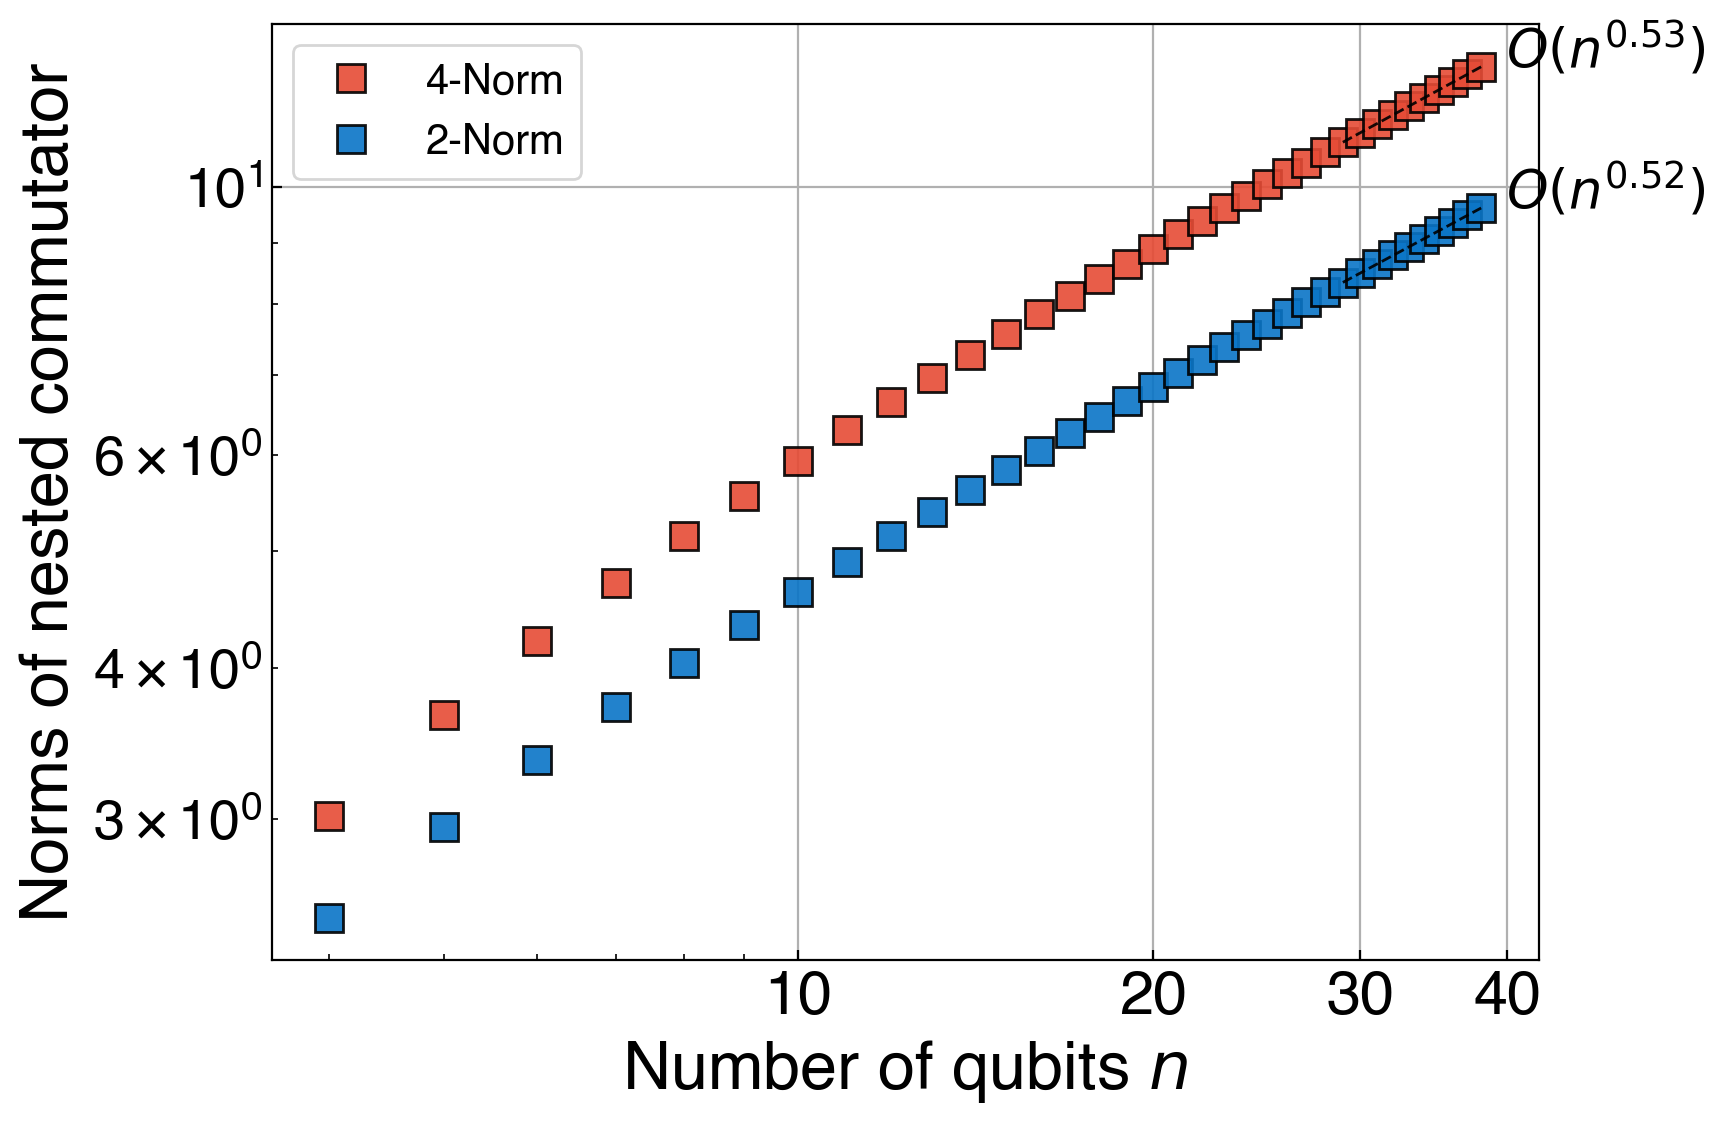

In [8]:
import time, pickle
def nested_commutator_4norm(h_list, p=2):
    L = len(h_list)
    # print('L:', L)
    if p == 2:
        sum_norm4 = 0
        for i in range(L):
            cmm = commutator(h_list[i], commutator(h_list[0], h_list[1]).simplify()).simplify()
            if i == 0:
                sum_norm4 += ((np.abs((cmm @ cmm).simplify().coeffs) ** 2).sum())**(1/4) / 2
            else:
                sum_norm4 += ((np.abs((cmm @ cmm).simplify().coeffs) ** 2).sum())**(1/4)
        return sum_norm4

def nested_commutator_2norm(h_list, p=2):
    L = len(h_list)
    # print('L:', L)
    if p == 2:
        sum_norm2 = 0
        for i in range(L):
            cmm = commutator(h_list[i], commutator(h_list[0], h_list[1]).simplify()).simplify()
            if i == 0:
                sum_norm2 += (np.abs((cmm @ cmm).simplify().coeffs[0]))**(1/2) / 2
            else:
                sum_norm2 += (np.abs((cmm @ cmm).simplify().coeffs[0]))**(1/2)
        return sum_norm2

n_list = np.arange(4, 39)
norm2_list, norm4_list = [], []
start_time = time.time()
for n in n_list:
    pow_law = Power_law(n, alpha=4, Jx=1, Jy=0, Jz=0, hx=0.0, hy=0.0, hz=0.2, pbc=False, verbose=False)
    # print('xyz group: ', pow_law.ham_xyz)
    norm4 = nested_commutator_4norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
    norm2 = nested_commutator_2norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
    print(f'------ n = {n}, eeee:{norm4} ------')
    norm4_list.append(norm4)
    norm2_list.append(norm2)

with open(f'{data_dir}/norm4_n={n_list[-1]}.pkl', 'wb') as f:
    pickle.dump(norm4_list, f)
    pickle.dump(norm2_list, f)
end_time = time.time()
print('Time taken:', end_time - start_time)

with open(f'{data_dir}/norm4_n={n_list[-1]}.pkl', 'rb') as f:
    norm4_list = pickle.load(f)
    norm2_list = pickle.load(f)

plt.rc('ytick', labelsize=LARGE_SIZE) 
plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(n_list, norm4_list, 's', label='4-Norm')
plot_fit(ax, n_list[25:], norm4_list[25:], var='n', x_offset=1.05)
ax.plot(n_list, norm2_list, 's', label='2-Norm')
plot_fit(ax, n_list[25:], norm2_list[25:], var='n', x_offset=1.05)
ax.set_xlabel(rf'Number of qubits $n$')
ax.set_ylabel(rf'Norms of nested commutator')
# ax.set_ylabel(rf'4-norm of nested commutator')
# ax.set_ylabel(rf'4-norm of nested commutator, $T_4/d^{1/4}$')
ax.loglog(); ax.grid(); ax.legend()
# ax.set_xticks(n_list)
ax.set_xticks([10, 20, 30, 40])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig(rf'{figs_dir}/nested_commutator_4norm_2norm.pdf', dpi=150, bbox_inches='tight')

## Relatex analytical bound

------ n = 2 ------
c1 (analy)=0.16000000000000003, c2=0.9600000000000001
Relaxed norm1: 0.16000000000000003 Exact norm1: 0.16000000000000003
Relaxed norm2: 0.9600000000000001 Exact norm2: 0.8158431221748457
------ n = 3 ------
c1 (analy)=1.9200000000000002, c2=1.12
Relaxed norm1: 1.9200000000000004 Exact norm1: 1.1537764081484767
Relaxed norm2: 1.12 Exact norm2: 0.8313843876330612
------ n = 4 ------
c1 (analy)=2.08, c2=2.8800000000000003
Relaxed norm1: 2.0800000000000005 Exact norm1: 1.2719551089153855
Relaxed norm2: 2.880000000000001 Exact norm2: 1.8242806801586213
------ n = 5 ------
c1 (analy)=3.8400000000000003, c2=3.0400000000000005
Relaxed norm1: 3.8400000000000003 Exact norm1: 2.2289248607873016
Relaxed norm2: 3.040000000000001 Exact norm2: 1.844952987605636
------ n = 6 ------
c1 (analy)=4.0, c2=4.8
Relaxed norm1: 4.0 Exact norm1: 2.329728802880907
Relaxed norm2: 4.800000000000001 Exact norm2: 2.8505225885452674
------ n = 7 ------
c1 (analy)=5.760000000000001, c2=4.96
Relaxe

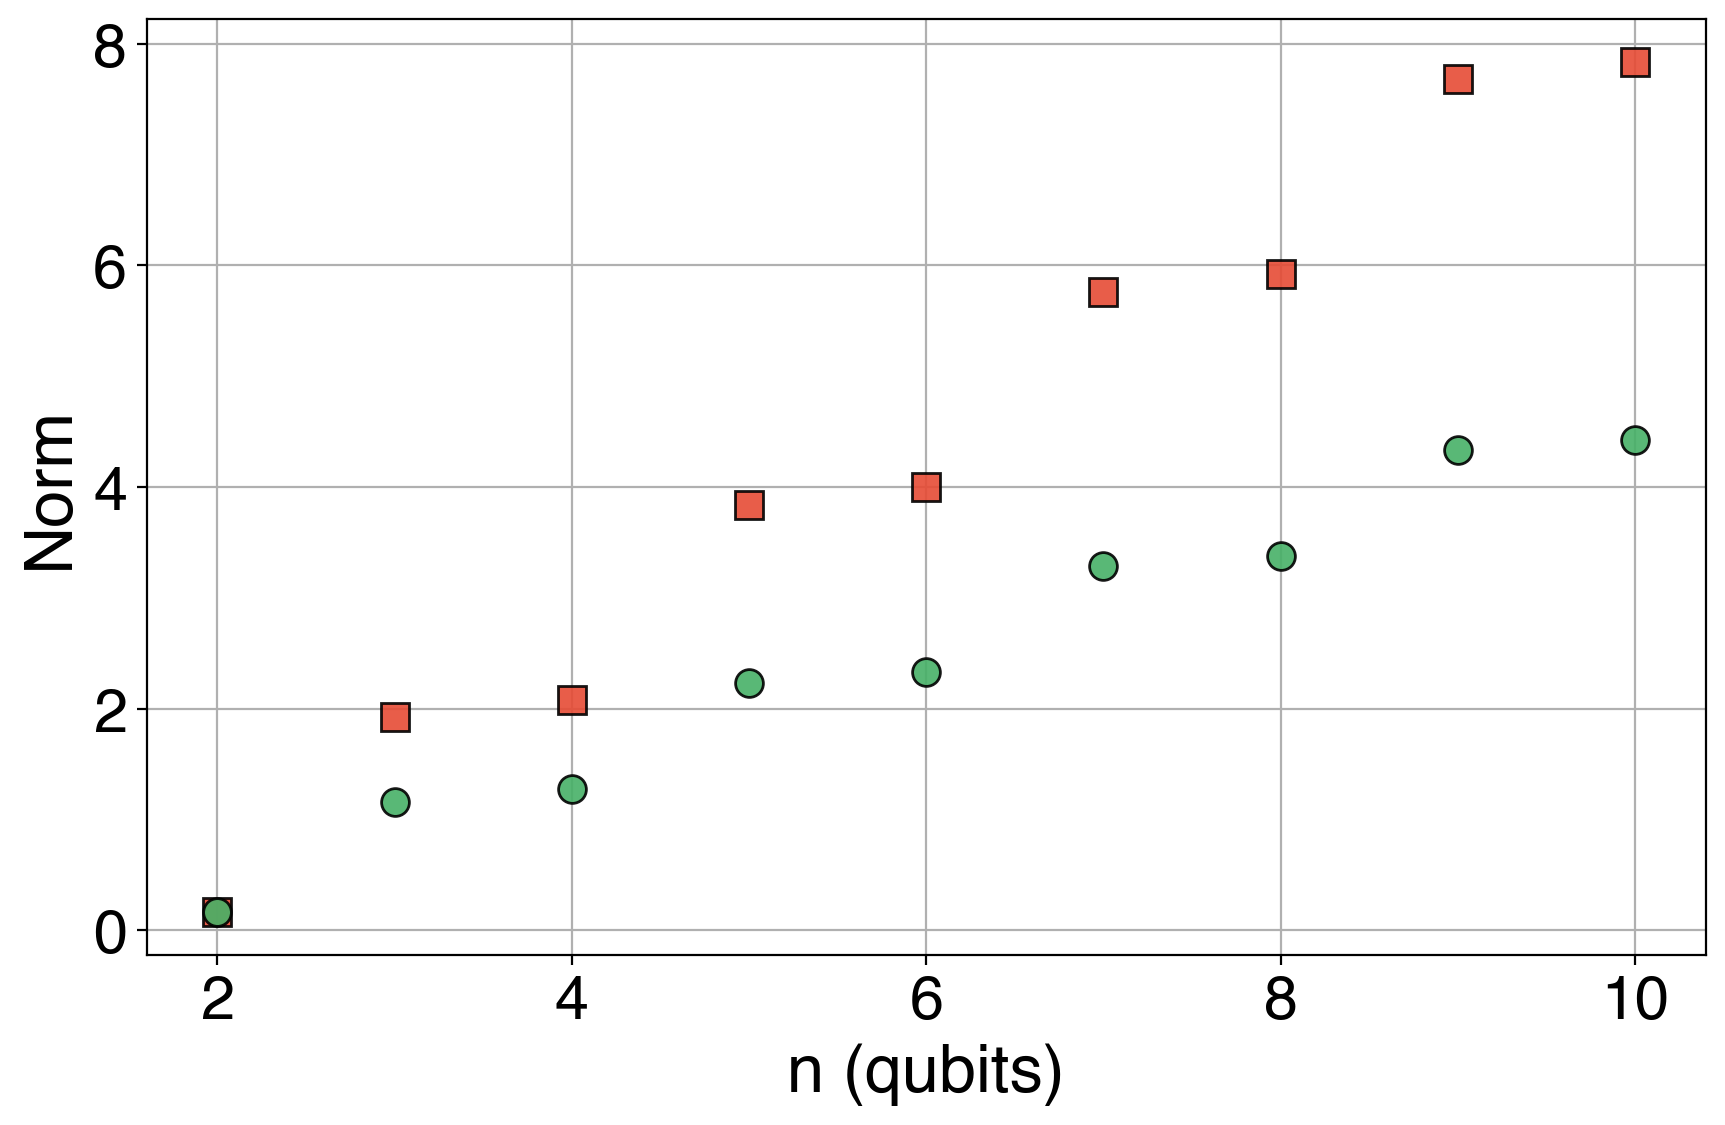

In [10]:
from spin_ham import *
from trotter import *
import numpy 
from bounds import *

# J, h = 5, 0.3
J, h = 1, 0.2
n = 500
appro_list = []
exact_list = []
# hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
# cmm = commutator(hnn.ham_par[1], commutator(hnn.ham_par[1], hnn.ham_par[0]).simplify()).simplify()
# cmm.coeffs
n_list = np.arange(2, 11)
for n in n_list:
    print(f'------ n = {n} ------')
    hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    cmm1 = commutator(hnn.ham_par[1], commutator(hnn.ham_par[1], hnn.ham_par[0]).simplify()).simplify()
    cmm2 = commutator(hnn.ham_par[0], commutator(hnn.ham_par[0], hnn.ham_par[1]).simplify()).simplify()
    relaxed_norm1 = numpy.linalg.norm(cmm1.coeffs, ord=1)
    exact_norm1 = numpy.linalg.norm(cmm1, ord=2)
    relaxed_norm2 = numpy.linalg.norm(cmm2.coeffs, ord=1)
    exact_norm2 = numpy.linalg.norm(cmm2, ord=2)
    exact_list.append(exact_norm1)
    appro_list.append(relaxed_norm1)
    analytic_loose_commutator_bound(n, J, h, 1, verbose=True)
    print('Relaxed norm1:', relaxed_norm1, 'Exact norm1:', exact_norm1)
    print('Relaxed norm2:', relaxed_norm2, 'Exact norm2:', exact_norm2)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(n_list, appro_list, 's', label='Approximated')
ax.plot(n_list, exact_list, 'o', label='Exact') 
# ax.plot(n_list, np.divide(appro_list, exact_list), 'o', label='Exact') 
ax.set_xlabel(rf'n (qubits)')
ax.set_ylabel(rf'Norm') 
# ax.loglog(); 
ax.grid()  

In [7]:
hnn = Nearest_Neighbour_1d(4, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
commutator(hnn.ham_par[1], commutator(hnn.ham_par[1], hnn.ham_par[0])).simplify()

SparsePauliOp(['IIZZ', 'ZZII', 'IXII', 'IZXZ', 'IYYI'],
              coeffs=[ 0.16+0.j,  0.16+0.j,  0.8 +0.j, -0.8 +0.j,  0.16+0.j])

n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
n = 10
n = 11
n = 12
n = 13
n = 14


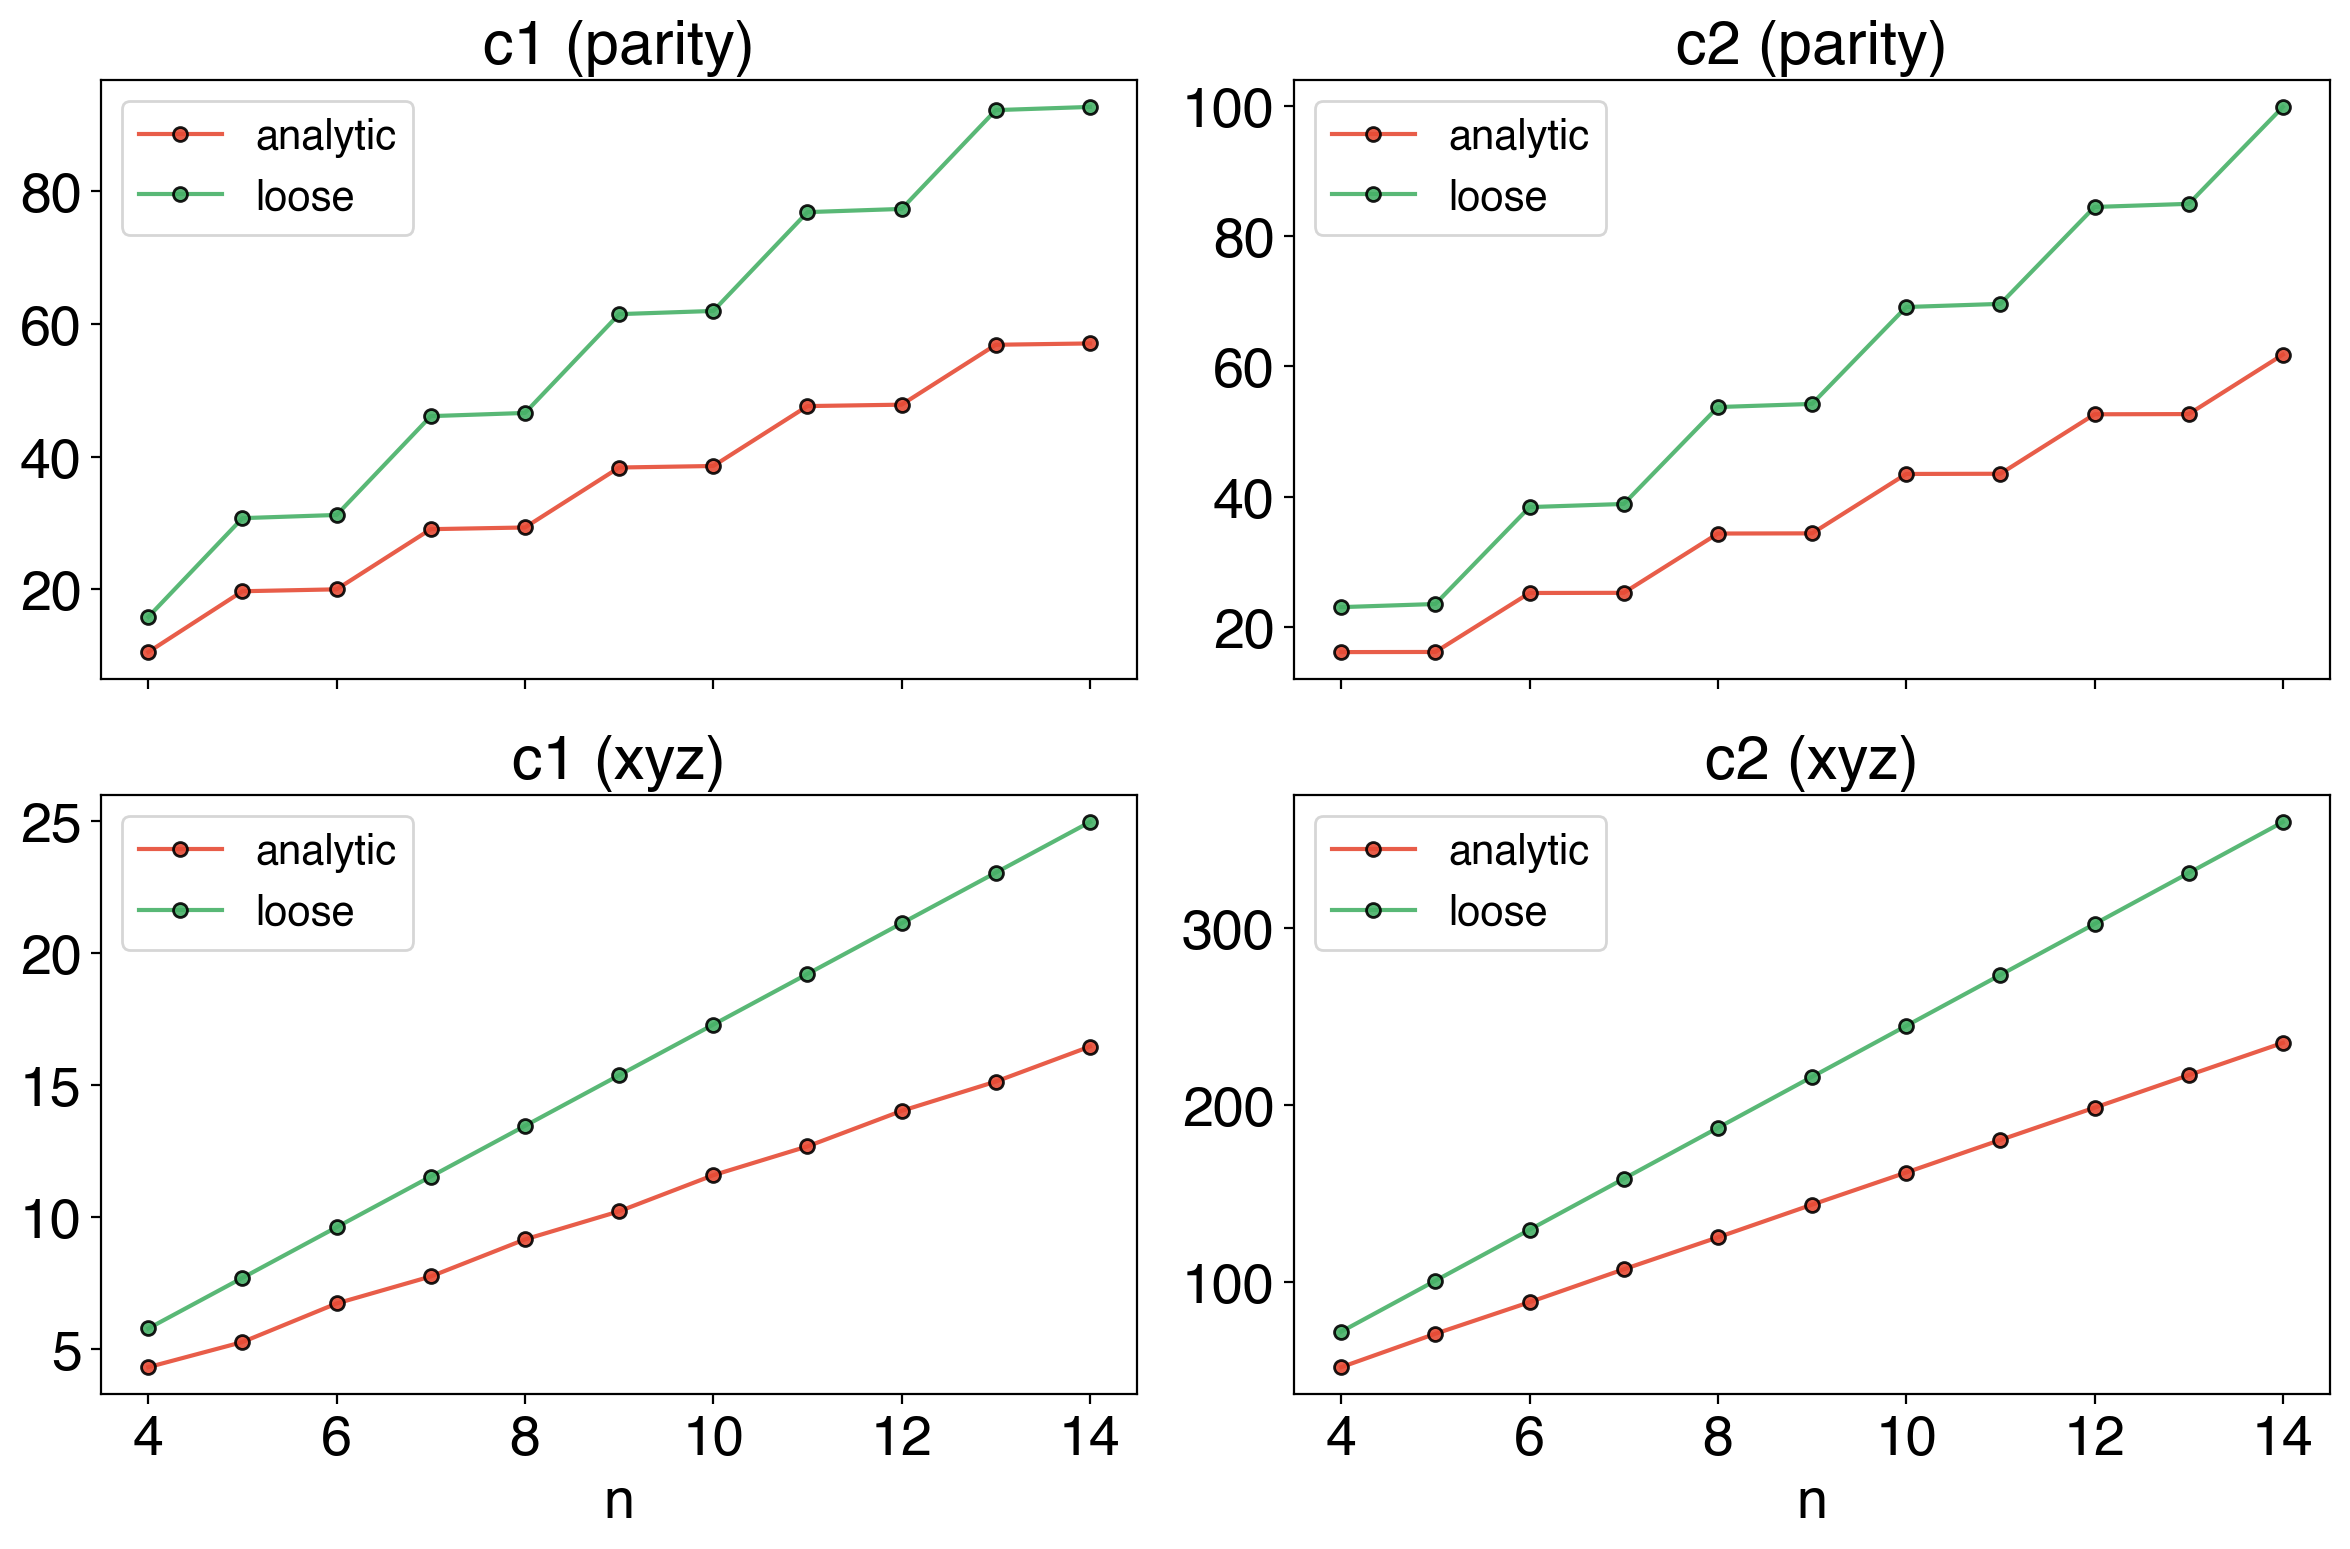

In [7]:
from spin_ham import TF_Ising_1d
n_list = [4, 5, 6, 7, 8, 9, 10, 11, 12]
# n_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
J, h = 3, 0.2
par_c1_dict = dict({'analytic': [], 'loose': []})
par_c2_dict = dict({'analytic': [], 'loose': []})
xyz_c1_dict = dict({'analytic': [], 'loose': []})
xyz_c2_dict = dict({'analytic': [], 'loose': []})
for n in n_list:
    print(f'n = {n}')
    tfI = TF_Ising_1d(n, J, h)
    # print('Hamiltonian: ', tfI.ham)
    # print(commutator(tfI.ham_parity[0], tfI.ham_parity[1]).simplify())
    c1_par_commutator = commutator(tfI.ham_parity[1], commutator(tfI.ham_parity[1], tfI.ham_parity[0])).simplify()
    # print("c1_xyz_commutator: ", c1_par_commutator, "\n norm: ", norm(c1_par_commutator, ord=2))
    c2_par_commutator = commutator(tfI.ham_parity[0], commutator(tfI.ham_parity[0], tfI.ham_parity[1])).simplify()
    par_c1_dict['analytic'].append(norm(c1_par_commutator, ord=2))
    par_c1_dict['loose'].append(analytic_loose_commutator_bound_parity(n, J, h, 1)[1])
    par_c2_dict['analytic'].append(norm(c2_par_commutator, ord=2))
    par_c2_dict['loose'].append(analytic_loose_commutator_bound_parity(n, J, h, 1)[2])
    # print("c2_xyz_commutator: ", c2_par_commutator, "\n norm: ", norm(c2_par_commutator, ord=2))

    # print(commutator(tfI.ham_xyz[0], tfI.ham_xyz[1]).simplify())
    c1_xyz_commutator = commutator(tfI.ham_xyz[1], commutator(tfI.ham_xyz[1], tfI.ham_xyz[0])).simplify()
    # print("c1_xyz_commutator: ", c1_xyz_commutator, "\n norm: ", norm(c1_xyz_commutator, ord=2))
    c2_xyz_commutator = commutator(tfI.ham_xyz[0], commutator(tfI.ham_xyz[0], tfI.ham_xyz[1])).simplify()
    # print("c2_xyz_commutator: ", c2_xyz_commutator, "\n norm: ", norm(c2_xyz_commutator, ord=2))
    xyz_c1_dict['analytic'].append(norm(c1_xyz_commutator, ord=2))
    xyz_c1_dict['loose'].append(analytic_loose_commutator_bound_xyz(n, J, h, 1)[1])
    xyz_c2_dict['analytic'].append(norm(c2_xyz_commutator, ord=2))
    xyz_c2_dict['loose'].append(analytic_loose_commutator_bound_xyz(n, J, h, 1)[2])

# print(c1_dict)
# print(c2_dict)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, layout='tight')
axes[0][0].plot(n_list, par_c1_dict['analytic'], '.-', label='analytic')
axes[0][0].plot(n_list, par_c1_dict['loose'], '.-', label='loose')
axes[0][1].plot(n_list, par_c2_dict['analytic'], '.-', label='analytic')
axes[0][1].plot(n_list, par_c2_dict['loose'], '.-', label='loose')
axes[1][0].plot(n_list, xyz_c1_dict['analytic'], '.-', label='analytic')
axes[1][0].plot(n_list, xyz_c1_dict['loose'], '.-', label='loose')
axes[1][1].plot(n_list, xyz_c2_dict['analytic'], '.-', label='analytic')
axes[1][1].plot(n_list, xyz_c2_dict['loose'], '.-', label='loose')
axes[0][0].set_title('c1 (parity)')
axes[0][1].set_title('c2 (parity)')
axes[1][0].set_title('c1 (xyz)')
axes[1][1].set_title('c2 (xyz)')
for ax in axes.flatten():
    ax.legend()
    # ax.loglog()
axes[1][0].set_xlabel('n')
axes[1][1].set_xlabel('n')
fig.savefig(f'{figs_dir}/loose_bound_compare_n={n_list[-1]}.pdf')

### Different groupings

In [14]:
SparsePauliOp.from_sparse_list([('X', [i], -h) for i in range(0, 2)] , num_qubits=4)

SparsePauliOp(['IIIX', 'IIXI'],
              coeffs=[-0.2+0.j, -0.2+0.j])

In [15]:
tfI4 = TF_Ising_1d(4, J, h)
tfI8 = TF_Ising_1d(8, J, h)
print('tfI8.ham: ', tfI8.ham.simplify())
# tfI4.ham_parity[0]
tfI8.ham_parity[0]
tfI8.ham_parity[1]
tfi8_0 = SparsePauliOp(['IIIIIIZZ', 'IIIIZZII', 'IIIIIIIX', 'IIIIIXII'], coeffs=[-1. +0.j, -1. +0.j, -0.2+0.j, -0.2+0.j])
tfi8_1 = SparsePauliOp(['IIIIIZZI', 'IIIIIIXI', 'IIIIXIII'], coeffs=[-1. +0.j, -0.2+0.j, -0.2+0.j])
tfi8_tail = SparsePauliOp(['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'], coeffs=[-1. +0.j,-1. +0.j, -1. +0.j, -1. +0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j])
# SparsePauliOp.from_sparse_list([*tfI4.zz_tuples, *tfI4.x_tuples, *tfI4.z_tuples], num_qubits=8)
# commutator(tfI4.ham_parity[0], tfI4.ham_parity[1]).simplify()
H_tfi8 = [tfi8_0, tfi8_1, tfi8_tail]

nested1 = commutator(sum(tfi8_1, tfi8_tail), commutator(sum(tfi8_1, tfi8_tail), tfi8_0))
nested2 = commutator(tfi8_tail, commutator(tfi8_1, tfi8_tail))
# print(nested1.simplify())
# print(nested2.simplify())
nested1.simplify() + nested2.simplify()

tfI8.ham:  SparsePauliOp(['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII', 'ZZIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[-3. +0.j, -3. +0.j, -3. +0.j, -3. +0.j, -3. +0.j, -3. +0.j, -3. +0.j,
 -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j,
 -0.2+0.j])


SparsePauliOp(['IIIIIIZZ', 'IIIIZZII', 'IIIIIXII', 'IIIZXZII', 'IIIIIZXZ', 'IIIIIYYI', 'IIIIXIII', 'IIIYYIII'],
              coeffs=[-0.16+0.j, -0.16+0.j, -0.8 +0.j,  0.8 +0.j,  0.8 +0.j, -0.16+0.j,
  0.8 +0.j,  0.16+0.j])

In [17]:
nested1 = commutator(tfi8_0, commutator(tfi8_0, sum(tfi8_1, tfi8_tail)))
nested2 = commutator(tfi8_1, commutator(tfi8_1, tfi8_tail))
# print(nested1.simplify())
print(nested2.simplify())
# nested1.simplify() + nested2.simplify()

SparsePauliOp(['IIIZZIII'],
              coeffs=[-0.16+0.j])


In [18]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
n = 2; t = 1
r = 5

tfI = TF_Ising_1d(n, J, h)
# print("Parity grouping: ", tfI.ham_parity)
# print("XYZ grouping: ", tfI.ham_xyz)
xyz_commutator = commutator(tfI.ham_xyz[0], tfI.ham_xyz[1]).simplify()
# tfI.ham_parity
# print("xyz_commutator: \n", xyz_commutator, "\n norm: ", norm(xyz_commutator, ord=2))
c1_xyz_commutator = commutator(tfI.ham_xyz[1], commutator(tfI.ham_xyz[1], tfI.ham_xyz[0])).simplify()
print("c1_xyz_commutator: \n", c1_xyz_commutator, "\n c1 norm: ", norm(c1_xyz_commutator, ord=2))
c2_xyz_commutator = commutator(tfI.ham_xyz[0], commutator(tfI.ham_xyz[0], tfI.ham_xyz[1])).simplify()
print("c2_xyz_commutator: \n", c2_xyz_commutator, "\n c2 norm: ", norm(c2_xyz_commutator, ord=2))
print(analytic_loose_commutator_bound_xyz(n, J, h, t/r))
# print(8*J*h**2, 4*J**2*h)

par_commutator = commutator(tfI.ham_parity[0], tfI.ham_parity[1]).simplify()
# print("par_commutator: ", par_commutator, "\n norm: ", norm(par_commutator, ord=2))
c1_par_commutator = commutator(tfI.ham_parity[1], commutator(tfI.ham_parity[1], tfI.ham_parity[0])).simplify()
print("c1_par_commutator: ", c1_par_commutator, "\n norm: ", norm(c1_par_commutator, ord=2))
c2_par_commutator = commutator(tfI.ham_parity[0], commutator(tfI.ham_parity[0], tfI.ham_parity[1])).simplify()
print("c2_par_commutator: ", c2_par_commutator, "\n norm: ", norm(c2_par_commutator, ord=2))
print(analytic_loose_commutator_bound_parity(n, J, h, t/r))
# print(4*J*h**2, 4*J**2*h)
# print(norm(xyz_commutator, ord=2))
# print(norm(par_commutator, ord=2))

c1_xyz_commutator: 
 SparsePauliOp(['ZZ', 'YY'],
              coeffs=[-0.32+0.j,  0.32+0.j]) 
 c1 norm:  0.6400000000000002
c2_xyz_commutator: 
 SparsePauliOp(['IX', 'XI'],
              coeffs=[-0.8+0.j, -0.8+0.j]) 
 c2 norm:  1.6
(0.0009600000000000003, 0.6400000000000001, 1.6)
c1_par_commutator:  SparsePauliOp(['ZZ'],
              coeffs=[-0.16+0.j]) 
 norm:  0.16000000000000003
c2_par_commutator:  SparsePauliOp(['XI', 'YY'],
              coeffs=[-0.8 +0.j, -0.16+0.j]) 
 norm:  0.8158431221748457
(0.00042666666666666683, 0.16000000000000003, 0.9600000000000001)


In [19]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
n = 3; t = 1
r = 5

tfI = TF_Ising_1d(n, J, h)
# print("Parity grouping: ", tfI.ham_parity)
# print("XYZ grouping: ", tfI.ham_xyz)
xyz_commutator = commutator(tfI.ham_xyz[0], tfI.ham_xyz[1]).simplify()
# tfI.ham_parity
# print("xyz_commutator: \n", xyz_commutator, "\n norm: ", norm(xyz_commutator, ord=2))
c1_xyz_commutator = commutator(tfI.ham_xyz[1], commutator(tfI.ham_xyz[1], tfI.ham_xyz[0])).simplify()
print("c1_xyz_commutator: \n", c1_xyz_commutator, "\n c1 norm: ", norm(c1_xyz_commutator, ord=2))
c2_xyz_commutator = commutator(tfI.ham_xyz[0], commutator(tfI.ham_xyz[0], tfI.ham_xyz[1])).simplify()
print("c2_xyz_commutator: \n", c2_xyz_commutator, "\n c2 norm: ", norm(c2_xyz_commutator, ord=2))
print(analytic_loose_commutator_bound_xyz(n, J, h, t/r))
# print(8*J*h**2, 4*J**2*h)

par_commutator = commutator(tfI.ham_parity[1], tfI.ham_parity[0]).simplify()
# print("par_commutator: ", par_commutator, "\n norm: ", norm(par_commutator, ord=2))
c1_par_commutator = commutator(tfI.ham_parity[0], commutator(tfI.ham_parity[0], tfI.ham_parity[1])).simplify()
print("c1_par_commutator: ", c1_par_commutator, "\n norm: ", norm(c1_par_commutator, ord=2))
c2_par_commutator = commutator(tfI.ham_parity[1], commutator(tfI.ham_parity[1], tfI.ham_parity[0])).simplify()
print("c2_par_commutator: ", c2_par_commutator, "\n norm: ", norm(c2_par_commutator, ord=2))
print(analytic_loose_commutator_bound_parity(n, J, h, t/r))
# print(4*J*h**2, 4*J**2*h)
# print(norm(xyz_commutator, ord=2))
# print(norm(par_commutator, ord=2))

c1_xyz_commutator: 
 SparsePauliOp(['IZZ', 'ZZI', 'IYY', 'YYI'],
              coeffs=[-0.32+0.j, -0.32+0.j,  0.32+0.j,  0.32+0.j]) 
 c1 norm:  0.9050966799187812
c2_xyz_commutator: 
 SparsePauliOp(['IIX', 'IXI', 'XII', 'ZXZ'],
              coeffs=[-0.8+0.j, -1.6+0.j, -0.8+0.j, -1.6+0.j]) 
 c2 norm:  3.862741699796953
(0.0024533333333333343, 1.2800000000000002, 4.800000000000001)
c1_par_commutator:  SparsePauliOp(['ZZI', 'IXI', 'IYY'],
              coeffs=[-0.16+0.j, -0.8 +0.j, -0.16+0.j]) 
 norm:  0.8313843876330612
c2_par_commutator:  SparsePauliOp(['IZZ', 'XII', 'ZXZ', 'YYI'],
              coeffs=[-0.16+0.j, -0.8 +0.j,  0.8 +0.j, -0.16+0.j]) 
 norm:  1.153776408148477
(0.001653333333333334, 1.9200000000000002, 1.12)


In [20]:
tfi8_0 = SparsePauliOp(['IIIIIIZZ', 'IIIIIIIX'], coeffs=[-1. +0.j, -0.2+0.j])
tfi8_1 = SparsePauliOp([ 'IIIIIIXI'], coeffs=[-0.2+0.j])
tfi8_tail = SparsePauliOp(['IIIIIZZI','ZZIIIIII', 'IIIIZZII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII', 'IIIIIXII'], coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,-1. +0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j])
# SparsePauliOp.from_sparse_list([*tfI4.zz_tuples, *tfI4.x_tuples, *tfI4.z_tuples], num_qubits=8)
# commutator(tfI4.ham_parity[0], tfI4.ham_parity[1]).simplify()
H_tfi8 = [tfi8_0, tfi8_1, tfi8_tail]

c1_nested1 = commutator(sum(tfi8_1, tfi8_tail), commutator(sum(tfi8_1, tfi8_tail), tfi8_0))
c1_nested2 = commutator(tfi8_tail, commutator(tfi8_1, tfi8_tail))
print(c1_nested1.simplify())
print(c1_nested2.simplify())
print('c1: ', (c1_nested1 + c1_nested2).simplify())
# commutator(tfi8_0, tfi8_tail).simplify()

c2_nested1 = commutator(tfi8_0, commutator(tfi8_0, sum(tfi8_1, tfi8_tail)))
c2_nested2 = commutator(tfi8_1, commutator(tfi8_1, tfi8_tail))
print(c2_nested1.simplify())
print(c2_nested2.simplify())
print('c2: ', (c2_nested1 + c2_nested2).simplify())

SparsePauliOp(['IIIIIIZZ', 'IIIIIZXZ'],
              coeffs=[-0.16+0.j,  0.8 +0.j])
SparsePauliOp(['IIIIIIXI', 'IIIIIYYI'],
              coeffs=[0.8 +0.j, 0.16+0.j])
c1:  SparsePauliOp(['IIIIIIZZ', 'IIIIIZXZ', 'IIIIIIXI', 'IIIIIYYI'],
              coeffs=[-0.16+0.j,  0.8 +0.j,  0.8 +0.j,  0.16+0.j])
SparsePauliOp(['IIIIIIXI', 'IIIIIIYY'],
              coeffs=[-0.8 +0.j, -0.16+0.j])
SparsePauliOp(['IIIIIZZI'],
              coeffs=[-0.16+0.j])
c2:  SparsePauliOp(['IIIIIZZI', 'IIIIIIXI', 'IIIIIIYY'],
              coeffs=[-0.16+0.j, -0.8 +0.j, -0.16+0.j])


### r=3

In [23]:
tfi8_1 = SparsePauliOp(['IIIIIIZZ', 'IIIIIIIX', 'IIIIIXII'], coeffs=[-1. +0.j, -0.2+0.j, -0.2+0.j])
tfi8_0 = SparsePauliOp(['IIIIIZZI', 'IIIIIIXI'], coeffs=[-1. +0.j, -0.2+0.j])
tfi8_tail = SparsePauliOp(['ZZIIIIII', 'IIIIZZII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'], coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,-1. +0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j])
# SparsePauliOp.from_sparse_list([*tfI4.zz_tuples, *tfI4.x_tuples, *tfI4.z_tuples], num_qubits=8)
# commutator(tfI4.ham_parity[0], tfI4.ham_parity[1]).simplify()
H_tfi8 = [tfi8_0, tfi8_1, tfi8_tail]

nested1 = commutator(sum(tfi8_1, tfi8_tail), commutator(sum(tfi8_1, tfi8_tail), tfi8_0))
nested2 = commutator(tfi8_tail, commutator(tfi8_1, tfi8_tail))
print(nested1.simplify())
print(nested2.simplify())
nested1.simplify() + nested2.simplify()
# commutator(tfi8_0, tfi8_tail).simplify()

SparsePauliOp(['IIIIIZZI', 'IIIIIIXI', 'IIIIZXZI', 'IIIIIIYY'],
              coeffs=[-0.16+0.j, -0.8 +0.j,  0.8 +0.j, -0.16+0.j])
SparsePauliOp(['IIIIIXII', 'IIIIYYII'],
              coeffs=[0.8 +0.j, 0.16+0.j])


SparsePauliOp(['IIIIIZZI', 'IIIIIIXI', 'IIIIZXZI', 'IIIIIIYY', 'IIIIIXII', 'IIIIYYII'],
              coeffs=[-0.16+0.j, -0.8 +0.j,  0.8 +0.j, -0.16+0.j,  0.8 +0.j,  0.16+0.j])

In [25]:
print(tfi8_1)
print(tfi8_tail)
# commutator(tfi8_1, tfi8_tail).simplify()

SparsePauliOp(['IIIIIIZZ', 'IIIIIIIX', 'IIIIIXII'],
              coeffs=[-1. +0.j, -0.2+0.j, -0.2+0.j])
SparsePauliOp(['ZZIIIIII', 'IIIIZZII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -0.2+0.j, -0.2+0.j,
 -0.2+0.j, -0.2+0.j, -0.2+0.j])


In [26]:
nested1 = commutator(tfi8_0, commutator(tfi8_0, sum(tfi8_1, tfi8_tail)))
nested2 = commutator(tfi8_1, commutator(tfi8_1, tfi8_tail))
print(nested1.simplify())
print(nested2.simplify())
(nested1 + nested2).simplify()

SparsePauliOp(['IIIIIIZZ', 'IIIIIXII', 'IIIIIZXZ', 'IIIIIYYI'],
              coeffs=[-0.16+0.j, -0.8 +0.j,  0.8 +0.j, -0.16+0.j])
SparsePauliOp(['IIIIZZII'],
              coeffs=[-0.16+0.j])


SparsePauliOp(['IIIIZZII', 'IIIIIIZZ', 'IIIIIXII', 'IIIIIZXZ', 'IIIIIYYI'],
              coeffs=[-0.16+0.j, -0.16+0.j, -0.8 +0.j,  0.8 +0.j, -0.16+0.j])